### Creating the point grid.

To create the point grid, shapefiles are uploaded. The spacings used are 0.075 degrees for statewide, 0.05 degree for large districts, and 0.01 for small districts, which are changed in the 'by' variable. After the point grid for a state is created, the shapefile must be clipped to select the points within the congressional districts. The unclipped grids are saved as a geographic identifier (wa, cd01, cd02, etc...), then a three digit number (representing the degree spacing) followed by 'grid'. The clipped features follow the same naming convention, but with the suffix 'pts'. All of these can be found in the Shapes folder.

In [1]:
import pandas as pd
import os
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopandas import GeoDataFrame
from shapely.geometry import Polygon
import matplotlib as mpl

# This sets Jupyter Notebook to the 'inline' backend.
%matplotlib inline 
mpl.rcParams['figure.figsize'] = (14,14)

# Sets keys and projections.
# '4326' is the WGS84 projection. Check http://spatialreference.org/ref/sr-org/?page=1 for different projections.
nan = 'np.nan'
bing_api_key = ''
crs = {'init': 'esri:102273'}

# Sets up reading the state shapefile
shp = 'Shapes/Indiana/cb_2017_State_IN.shp'
us = gpd.read_file(shp)
wa = us[us['STUSPS']=="IN"]

# Point Grid size. Use 0.075 for statewide, 0.05 for large districts, 0.01 for small districts.
by = 0.075


# This creates the pandas data frame for the points grid.
pts_grid = (
    pd.concat([pd.DataFrame({'pts_lon' : np.arange(float(wa.bounds['minx']), float(wa.bounds['maxx']), by)})
       , (pd.DataFrame({'pts_lat' : np.arange(float(wa.bounds['miny']), float(wa.bounds['maxy']), by)})
          .pivot(columns = 'pts_lat', values = 'pts_lat'))]
        , axis = 1
             )
    .replace(method='ffill')
    .replace(method='bfill')
    .melt(id_vars=['pts_lon'])
    .drop('variable', 1)
    .rename(columns = {'value' : 'pts_lat'})
    .reset_index()
    .rename(columns={"index": "point_id"})
            )

# This sets the latitude and longitude of the points, then puts them into a geodataframe.
geometry_pts = [Point(xy) for xy in zip(pts_grid.pts_lon, pts_grid.pts_lat)]
gdf_pts_grid = GeoDataFrame(pts_grid, crs=crs, geometry=geometry_pts)

# This creates the plot of the point grid, setting the color of the shapefile and the background.
wa_plot = wa.plot(color='#C4C9CE', edgecolor='white')

# This plots the point grid over the shapefile.
(gdf_pts_grid
    .plot(ax=wa_plot, alpha = .3)
    .set_axis_off())

# This saves the point grid as a shapefile. It also shows the table for the point grid.
gdf_pts_grid.to_file("Shapes/Indiana/IN_grid.shp")
gdf_pts_grid

ValueError: Unstacked DataFrame is too big, causing int32 overflow

This is to ensure that the points were clipped correctly.

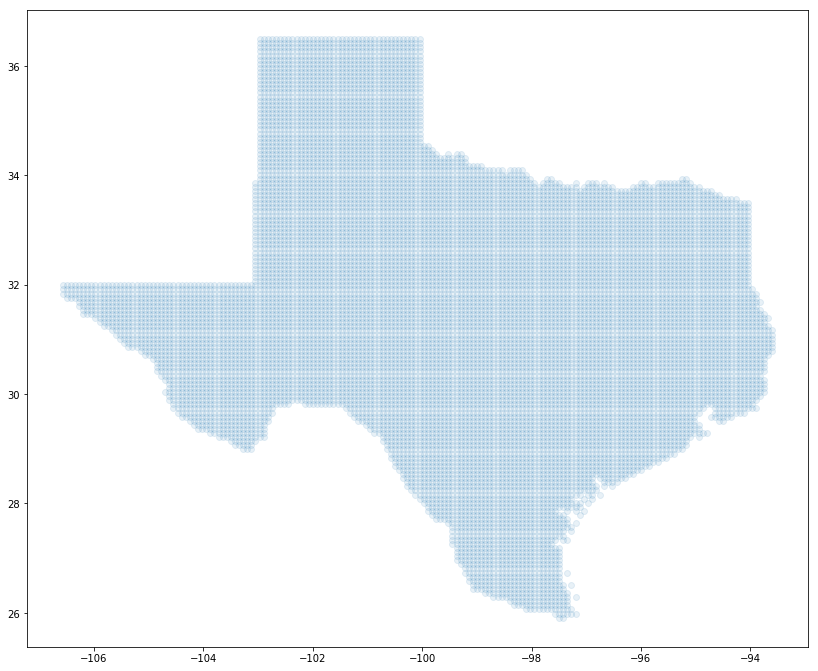

In [15]:
# This sets Jupyter Notebook to the 'inline' backend.
%matplotlib inline 
mpl.rcParams['figure.figsize'] = (14,14)

# This pulls in the shapefile of the points after clipping them.
pts = 'Shapes/Texas/TX_01grid_clip.shp'

# This reads the shapefile with geopandas then plots it.
wa_pt_grid = gpd.read_file(pts)
wa_pt_grid.plot(alpha = .1)

### Calculating Travel Time and Populating the Matrix

A distance matrix is comprised of a table of N by N dimensions. Each row and column of the cell value contains a 'similarity' between the heading and index (the first row and column) values. Travel times are used between each combination of points as the similarity, instead of the typical euclidean distances. This will be utilized in the Multidimensional Scaling script further on.

One important note: if the heading row and the index column are identical, then row 'X' and column 'Y' will have the same value as row 'Y' column 'X'. This symmetry can be used to reduce the number of geocoding requests that need to be made. This is used with the itertools library function called combinations. This function looks at a list of values and returns the second list of all possible unique combinations that exist within that list.

The Bing API is used below to build the distance matrix for a clipped district shapefile. The larger point spacing (0.075) is used here to accelerate the process in case it needs to be run multiple times.

In [13]:
from itertools import combinations
from random import randint
import json
from requests.exceptions import HTTPError
from urllib.error import URLError
import simplejson
import urllib
from datetime import datetime
from decimal import Decimal
from arcgis.features import SpatialDataFrame
import pickle
import geopandas as gpd
from arcgis import GIS

# Pulls the shapefiles for the congressional district and reads the file in geopandas.
file = 'Shapes/Pennsylvania/cb_2017_State_PA_CD_7_clip.shp'
CDgrid = gpd.read_file(file)

# This zips the lat/long into a single column.
CDgrid['lat,long'] = list(zip(CDgrid.pts_lat, CDgrid.pts_lon))

# This creates a list of all coordinates so it can be writen to NxN matrix.
xytups = CDgrid['lat,long'].tolist()

# This finds all the unique combinations of list entries. It them removes duplicate geocoding.
# This does assume that the travel time from A to B is equal to B to A.
unicombos = [comb for comb in combinations(xytups, 2)]  

# This shows how many points, unique combinations, and possible combinations for the shapefile.
pointcount = len(xytups)
totalcombinations = len(xytups)*len(xytups)
print('The amount of points in the shapefile is: ', pointcount)
print('The amount of unique combinations is: ', len(unicombos)) 
print('The total possible combinations for the shapefile is: ',totalcombinations)
   
# This creates the similarity matrix of n by n points.
dmatrix = pd.DataFrame(index = xytups, columns = xytups)
dmatrix

# This utilizes the Bing API to populate the matrix. 
length = len(unicombos)
key =''

 
for i in range(length):
    # This selects the target coordinate pairs in each unique tuple (origin, destination).
    origtup = unicombos[i][0]
    desttup = unicombos[i][1]
    
    # This selects the x and y coordinates for each of the pairs in the unique tuple.
    origx = unicombos[i][0][0]
    origy = unicombos[i][0][1]    
    destx = unicombos[i][1][0]
    desty = unicombos[i][1][1]
     
    # This casts coordinates to string for the API.    
    strox = str(origx)
    stroy = str(origy)
    strdx = str(destx)
    strdy = str(desty)
    
    # This calculates the travel times.
    # ttime = randint(1000,9999)
    try:
        url = 'http://dev.virtualearth.net/REST/V1/Routes/Driving?wp.0=' + strox + ',' + stroy + '&wp.1=' + strdx + ',' + strdy + '&key=' + key
        request = urllib.request.Request(url)
        response = urllib.request.urlopen(request)
    except HTTPError:
        ttime = Decimal('nan')
    except URLError:
        ttime = Decimal('nan')
    else:
        r = response.read().decode(encoding="utf-8")
        result = json.loads(r)
        ttime = (result["resourceSets"][0]["resources"][0]["travelDurationTraffic"])
    
    # This populates the matrix.
    dmatrix.loc[origtup, desttup]= ttime
    dmatrix.loc[desttup, origtup]= ttime
    # Setting travel time between identical points to 0, but MDS doesn't like zeros. 
    # This is easy to replace, just need to figure out what to replace with.
    dmatrix.loc[origtup, origtup]= 0 
    # This tries to catch the last NaN
    if i == length:
        dmatrix.loc[desttup, desttup] = 0

# This converts the matrix into a pickle file.
dmatrix.to_pickle('Shapes/Pennsylvania/cb_2017_State_PA_CD_7_clip.pkl')
print('Process completed for '+ file)

The amount of points in the shapefile is:  41
The amount of unique combinations is:  820
The total possible combinations for the shapefile is:  1681
Process completed for Shapes/Pennsylvania/cb_2017_State_PA_CD_7_clip.shp
